In [2]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

In [3]:
from dgym.envs.designer import Designer, Generator, StrictGenerator

designer = Designer(
    StrictGenerator(building_blocks, fingerprints),
    reactions,
    cache = True
)

In [1847]:
r = deck[0].reactants[1]
generator = designer.generator(r)

In [7]:
%%time
import torch

molecules = [deck[18].reactants[0]]
# molecules = [dg.molecule.Molecule('C1=CC=C=CC=C1')]

# Identify analogs of each original molecule
indices, scores, sizes = designer.generator.fingerprint_similarity(molecules)

# Add size similarity to score
original_sizes = torch.tensor([m.mol.GetNumAtoms() for m in molecules])
l1_norm = sizes - original_sizes[:, None]
scores += designer.generator.size_similarity(molecules, sizes)
samples_idx = torch.argsort(scores, descending=True)
samples = torch.gather(indices, 1, samples_idx).tolist()

CPU times: user 6.63 ms, sys: 0 ns, total: 6.63 ms
Wall time: 6.08 ms


In [10]:
%%time
from rdkit import Chem
prods = []
for idx, i in enumerate(samples[0]):
    bb = designer.generator.building_blocks[i]
    # if bb and bb.HasSubstructMatch(Chem.MolFromSmarts(
    #     '[*;R]1~[*;R]~[*;R]~[*;R]~[*;R]~[*;R]1'
    # )):
    if bb and bb.HasSubstructMatch(Chem.MolFromSmarts(
        '[*;R]1~[*;R]~[*;R]2~[*;R]~[*;R]~[*;R]~[*;R]~[*;R]2~[*;R]~[*;R]1'
    )):
        prods.append(bb)

# from rdkit.Chem.Draw import MolsToGridImage
# MolsToGridImage(prods[0:50], molsPerRow=10)

CPU times: user 76.4 ms, sys: 745 µs, total: 77.2 ms
Wall time: 82.9 ms


In [1509]:
patterns = [
    'CC', 'CCC', 'CCCC',
    'C1CCC1', 'C1CCCC1', 'C1CCCCC1',
    'C1CCCOC1', 'C1COCOC1', 'C1CCNCC1',
    'C1CNCOC1', 'C1NCNCC1', 'C1=CC=CC=C1',
    'C1CCC2CCCCC2C1',
    'c1ccc2ccccc2c1',
]

molecule = dg.molecule.Molecule(patterns[-1], reactants=['', ''])
generator = designer.generator(molecule)

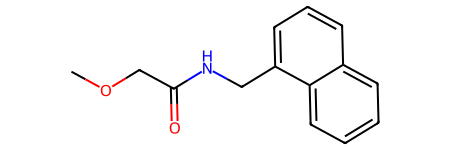

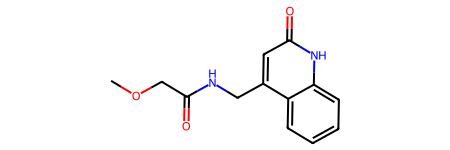

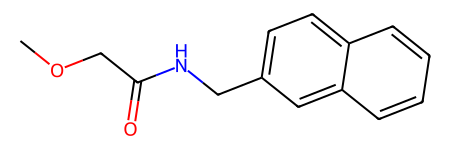

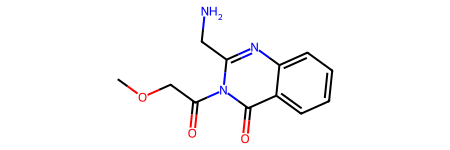

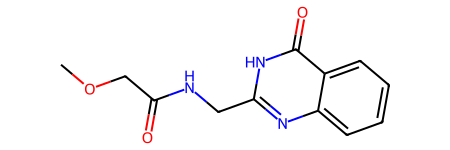

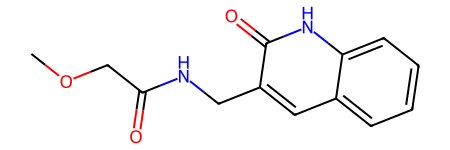

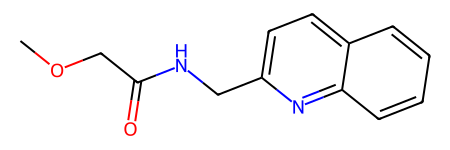

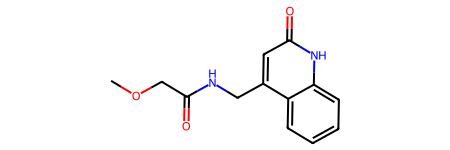

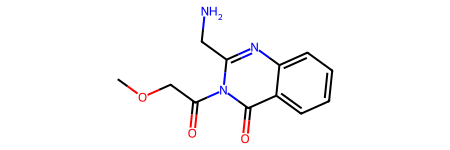

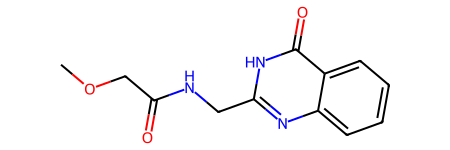

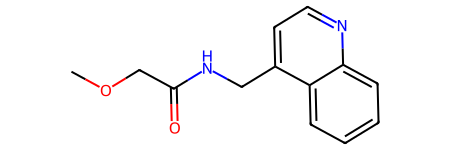

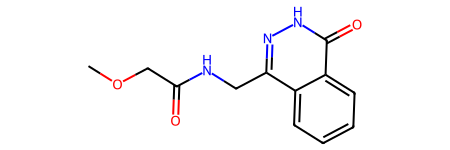

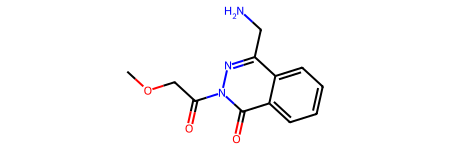

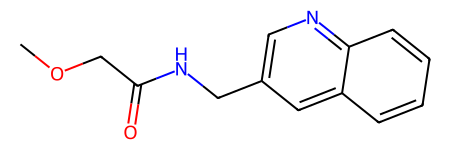

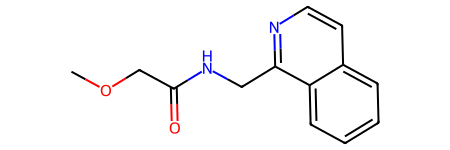

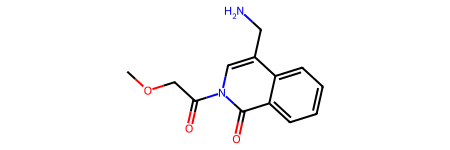

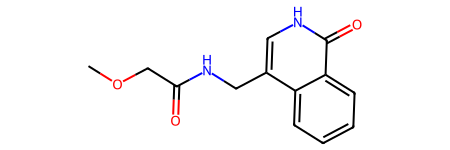

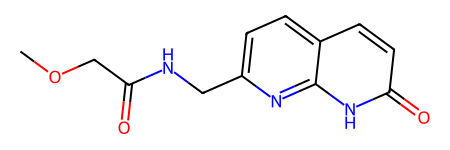

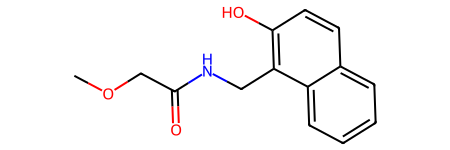

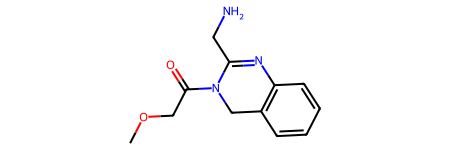

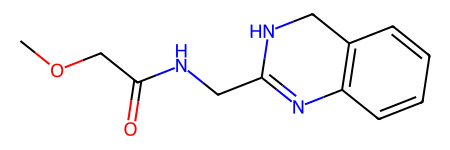

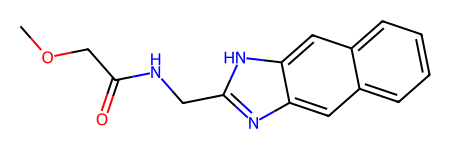

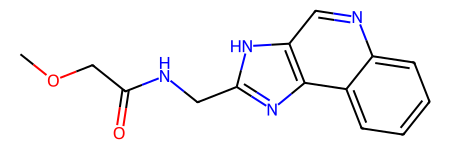

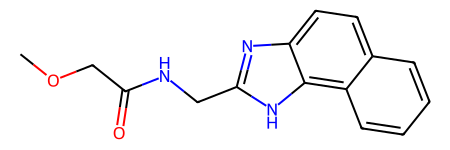

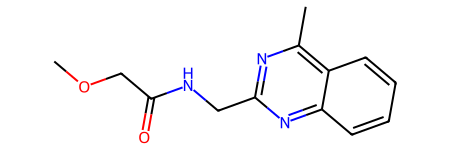

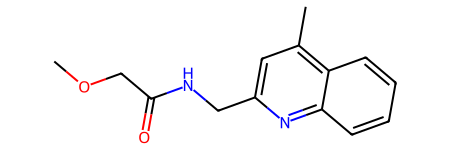

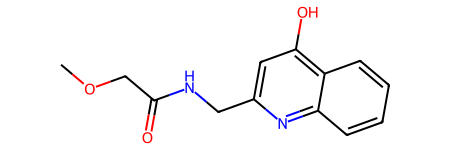

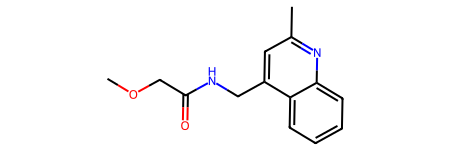

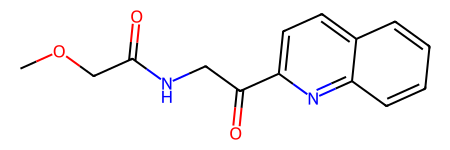

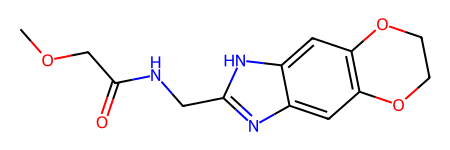

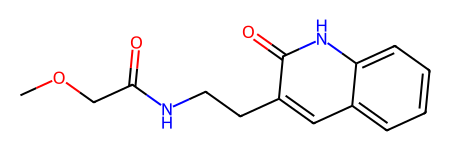

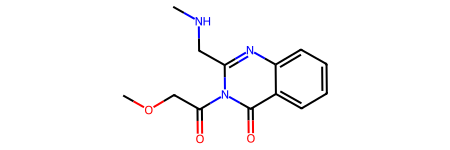

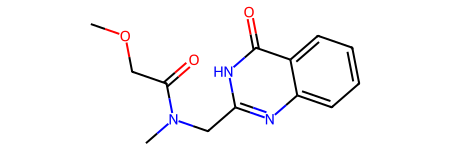

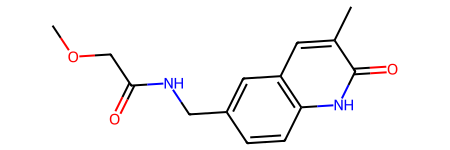

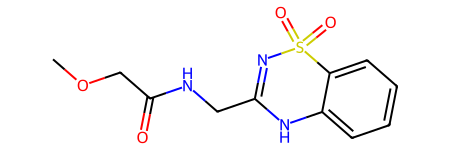

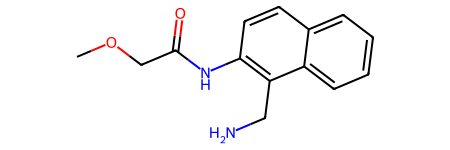

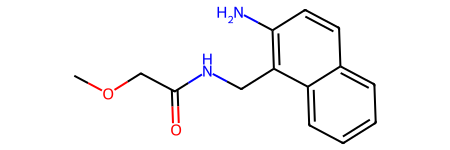

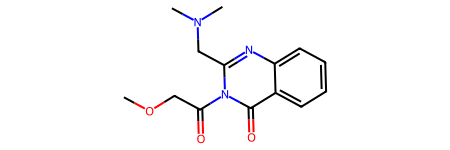

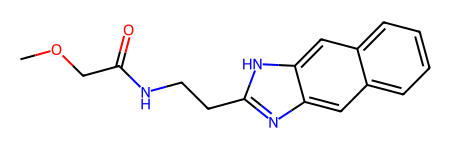

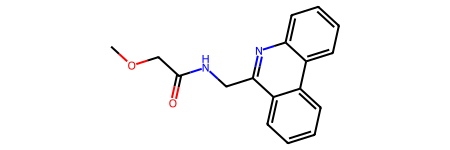

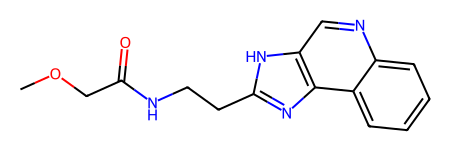

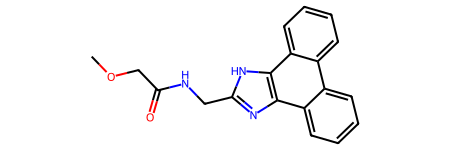

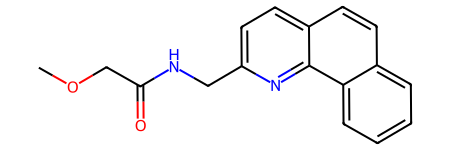

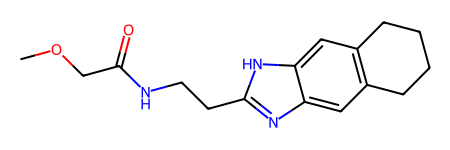

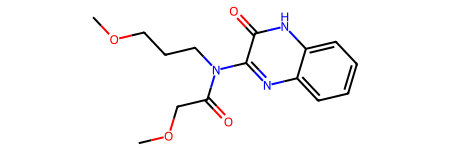

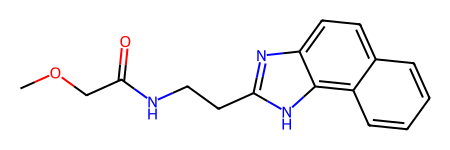

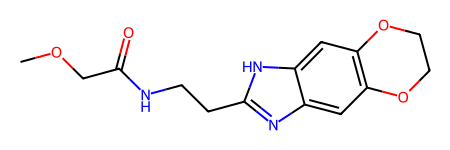

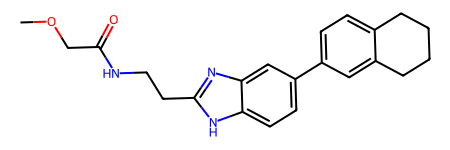

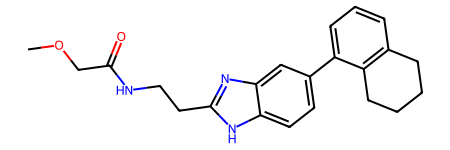

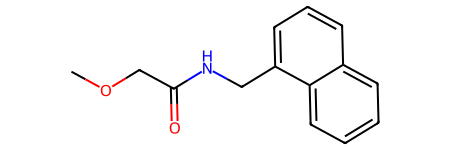

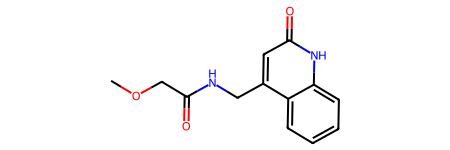

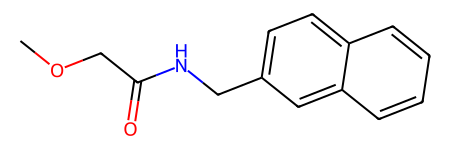

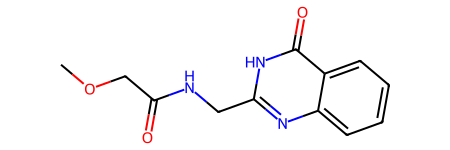

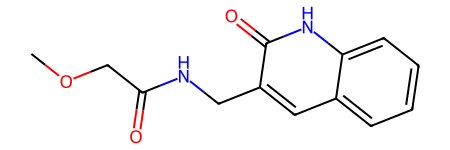

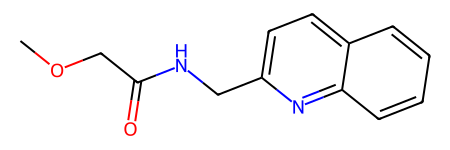

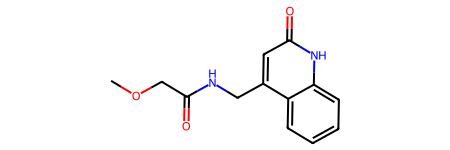

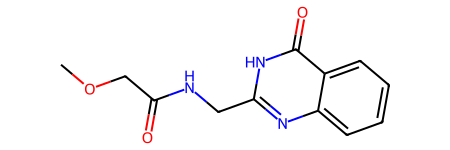

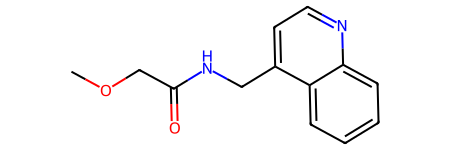

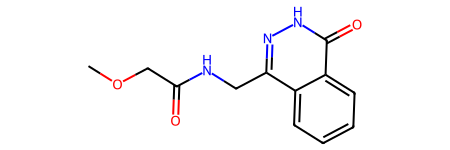

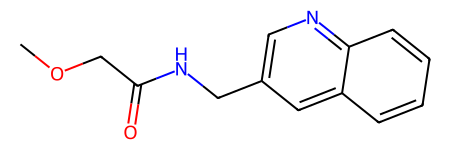

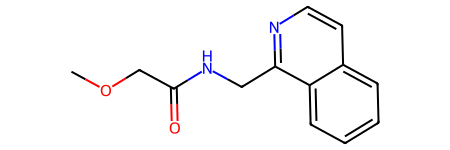

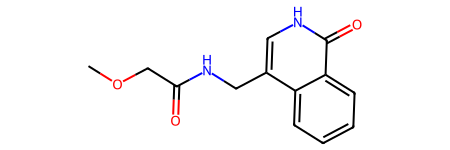

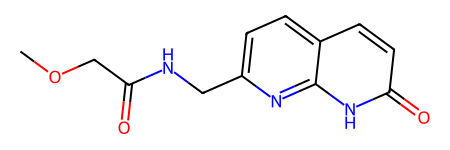

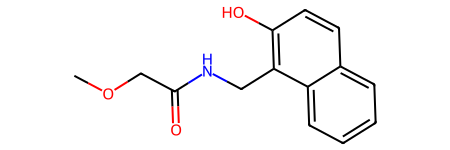

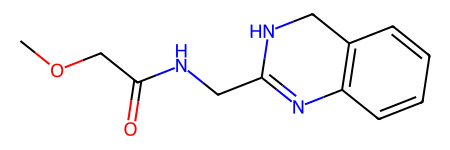

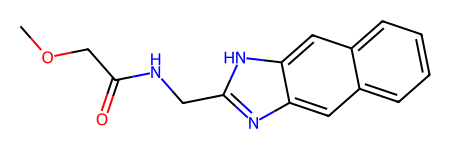

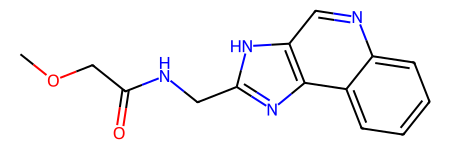

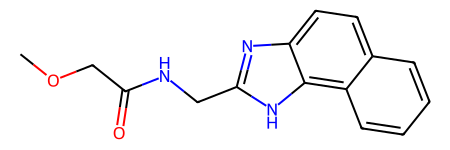

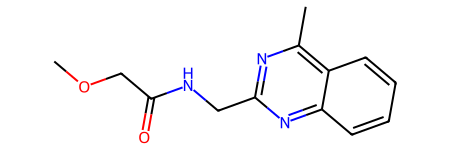

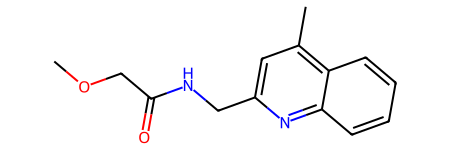

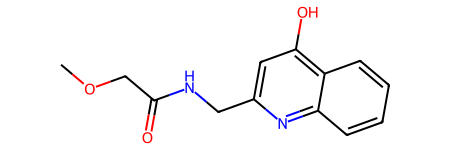

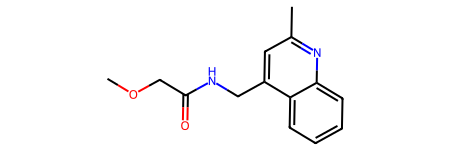

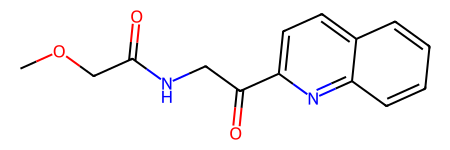

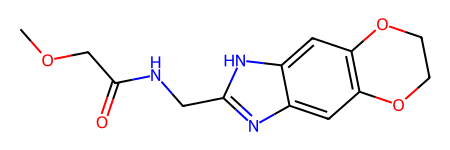

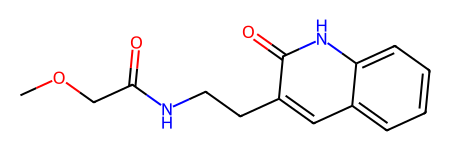

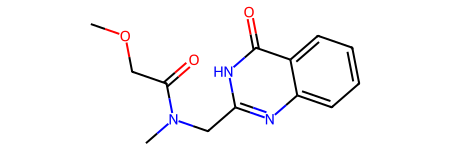

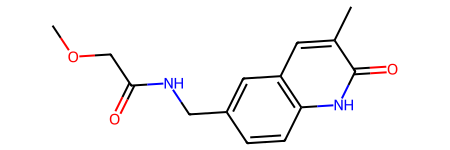

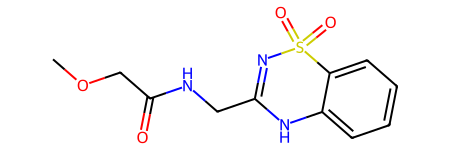

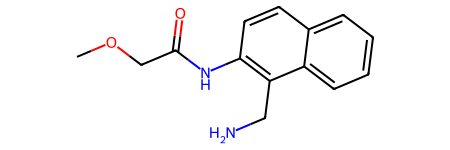

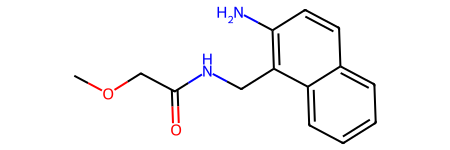

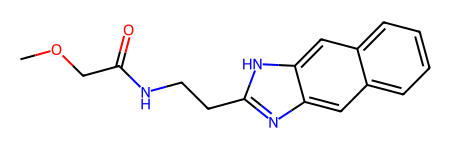

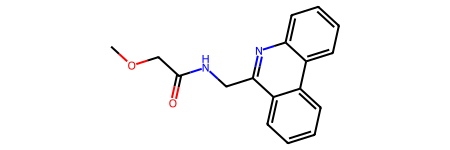

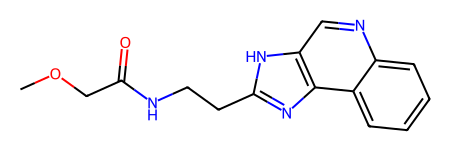

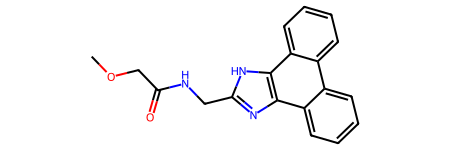

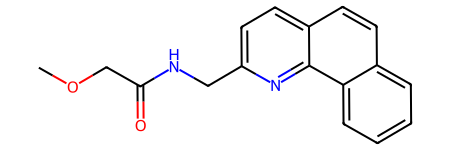

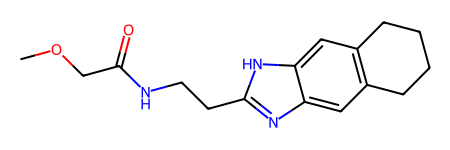

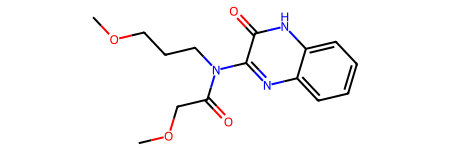

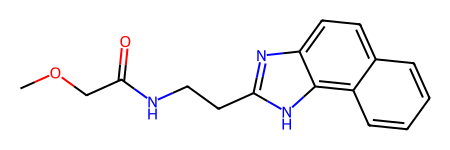

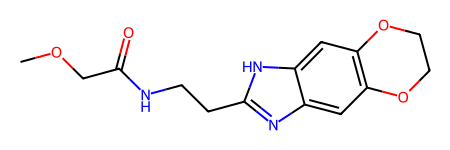

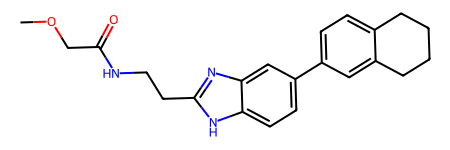

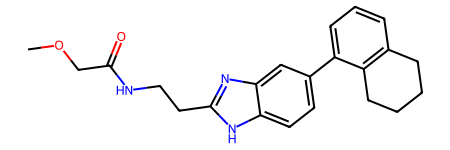

In [11]:
base_molecule = deck[18]
reactants = [base_molecule.reactants[0], designer.generator(base_molecule.reactants[1])]
for reaction in designer.match_reactions(base_molecule):
    with base_molecule.set_reaction(reaction):
        with base_molecule.set_reactants(reactants):
            analogs = designer.retrosynthesize(base_molecule, max_depth=1)
            for analog in analogs:
                display(analog)